# Image inpainting using GAN

Colab notebook นี้จัดทำขึ้นสำหรับใช้ในโครงการ Supper AI Engineer ในการแข่งขัน Hackathon ของศูนย์ภาคอีสาน

* ตัวอย่างนี้เป็นการใช้ Generative AI ช่วยในการเขียน code ทุกส่วนเกือบ 99% สามารถใช้งานได้โดยไม่มีการแก้ไขใด ๆ

* code บางส่วนที่ต้องแก้ไขเป็นเพียงส่วนที่ไม่ได้บอกข้อมูลให้ละเอียดเช่น  รูปแบบการทำ data augmentation, จำนวน epoch ที่ต้องการฝึก และชื่อคอลัมน์ในไฟล์ csv เนื้องจากความยาว prompt จำกัดไม่สามารถให้ข้อมูลเพิ่มได้เท่านั้น

* ข้อมูลได้มาจาก ภาพถ่ายจากการบิน drone โดยได้รับการอนุญาต และความร่วมมือ จากหลักสูตรภูมิสารสนเทศศาสตร์ (GIS) วิทยาลัยการคอมพิวเตอร์
มหาวิทยาลัยขอนแก่น



```
ดร.ไพรสันต์ ผดุงเวียง
หลักสูตรปัญญาประดิษฐ์ วิทยาลัยการคอมพิวเตอร์
มหาวิทยาลัยขอนแก่น สิงหาคม 2567
```



# Download data

โครงสร้างการเก็บข้อมูล

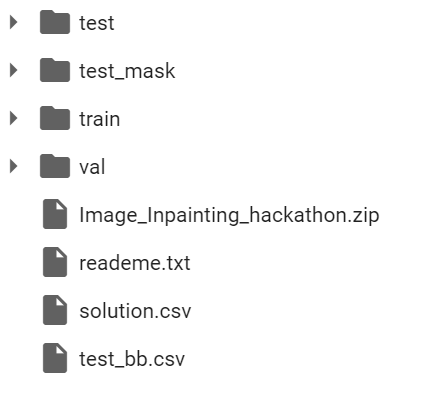

In [ ]:
# download data set

# สุ่มพื้นที่ขนาด 7x7 เพื่อลบข้อมูลในภาพออก

In [1]:
# prompt: create a function to randomly put a black box size 7*7 inside the given gray scale image then return the processed image and the mask.

import numpy as np
def create_masked_image(image):
  """
  Randomly puts a black box of size 7x7 inside the given grayscale image.

  Args:
    image: A NumPy array representing a grayscale image.

  Returns:
    A tuple containing:
      - The processed image with the black box.
      - The corresponding mask with 1s where the box is and 0s elsewhere.
  """

  # Create a copy of the image to avoid modifying the original.
  processed_image = image.copy()

  # Generate random coordinates for the top-left corner of the box.
  x = np.random.randint(0, image.shape[0] - 7)
  y = np.random.randint(0, image.shape[1] - 7)

  # Create the black box on the processed image.
  processed_image[x:x+7, y:y+7] = 0

  # Create the mask.
  mask = np.zeros_like(image)
  mask[x:x+7, y:y+7] = 1

  return processed_image, mask


# สร้าง Dataset เพื่อเตรียมใช้กับการฝึก

In [2]:
# prompt: create Dataset to load image from a given folder preprocess with function create_masked_image() and a given transformation then return image, processed image and mask

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class ImageInpaintingDataset(Dataset):
  def __init__(self, image_dir, transform=None):
    self.image_dir = image_dir
    self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
    self.transform = transform

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.image_files[idx])
    image = Image.open(img_path).convert('L')  # Convert to grayscale

    if self.transform:
      image = self.transform(image)

    processed_image, mask = create_masked_image(np.array(image))

    # Convert to PyTorch tensors
    image = transforms.ToTensor()(image)
    processed_image = transforms.ToTensor()(processed_image)
    mask = transforms.ToTensor()(mask)

    return image, processed_image, mask

# Example usage:
transform = transforms.Compose([
    # transforms.Resize((256, 256))
    # Add other transformations as needed
])


# สร้าง dataloader แบบประมวลผลภาพเบื้องต้นโดยใช้หลายซีพียูคอร์

In [3]:
# prompt: create data loader from /content/train, and /content/val in parallel by automatically get appropriate number of cpu core

import multiprocessing

# Get the number of CPU cores
num_workers = multiprocessing.cpu_count()

# Create datasets
train_dataset = ImageInpaintingDataset('/content/train', transform=transform)
val_dataset = ImageInpaintingDataset('/content/val', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers)


FileNotFoundError: [Errno 2] No such file or directory: '/content/train'

# สร้าง GAN โมเดล

In [6]:
import torch

# Create a tensor with shape [5, 1, 64, 64]
train_images = torch.randn(5, 1, 64, 64)

# Normalize the values to be between -1 and 1
train_images = torch.clamp(train_images, -1, 1)

In [36]:
# prompt: create Generative Adversarial Networks (GANs) model to fill in the black box to complete the image. the input image is gray scale 64*64 image with the black box and output is the complete image in the same size

import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Output pixel values in range [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output probability of real image
        )

    def forward(self, x):
        return self.model(x)


In [37]:
import torch

# Create a tensor with shape [5, 1, 64, 64]
train_images = torch.randn(5, 1, 64, 64)

# Normalize the values to be between -1 and 1
train_images = torch.clamp(train_images, -1, 1)

model1=Generator()
model2=Discriminator()
y=model1(train_images)
print(y.shape)
y2=model2(train_images)
print(y2.shape)


torch.Size([5, 1, 64, 64])
torch.Size([5, 1, 16, 16])


In [57]:


#GAN Architecture with ResNet50

import torch
import torch.nn as nn
import torchvision.models as models

# Generator
class Generator_s(nn.Module):
    def __init__(self):
        super(Generator_s, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # Modify the first convolutional layer to accept 1 input channel
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Output pixel values in range [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator
class Discriminator_s(nn.Module):
    def __init__(self):
        super(Discriminator_s, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # Modify the first convolutional layer to accept 1 input channel
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Change here
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Linear(2048, 1),
            nn.Sigmoid()  # Output probability of real image
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [58]:
import torch

# Create a tensor with shape [5, 1, 64, 64]
train_images = torch.randn(5, 1, 64, 64)

# Normalize the values to be between -1 and 1
train_images = torch.clamp(train_images, -1, 1)

model1=Generator_s()
model2=Discriminator_s()
y=model1(train_images)
print(y.shape)
y2=model2(train_images)
print(y2.shape)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([5, 1, 64, 64])
torch.Size([5, 1])


In [64]:
#model librally
def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


class AConv(nn.Module):
    def __init__(self, c1, c2):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        self.cv1 = Conv(c1, c2, 3, 2, 1)

    def forward(self, x):
        x = torch.nn.functional.avg_pool2d(x, 2, 1, 0, False, True)
        return self.cv1(x)


class ADown(nn.Module):
    def __init__(self, c1, c2):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        self.c = c2 // 2
        self.cv1 = Conv(c1 // 2, self.c, 3, 2, 1)
        self.cv2 = Conv(c1 // 2, self.c, 1, 1, 0)

    def forward(self, x):
        x = torch.nn.functional.avg_pool2d(x, 2, 1, 0, False, True)
        x1,x2 = x.chunk(2, 1)
        x1 = self.cv1(x1)
        x2 = torch.nn.functional.max_pool2d(x2, 3, 2, 1)
        x2 = self.cv2(x2)
        return torch.cat((x1, x2), 1)


class RepConvN(nn.Module):
    """RepConv is a basic rep-style block, including training and deploy status
    This code is based on https://github.com/DingXiaoH/RepVGG/blob/main/repvgg.py
    """
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=3, s=1, p=1, g=1, d=1, act=True, bn=False, deploy=False):
        super().__init__()
        assert k == 3 and p == 1
        self.g = g
        self.c1 = c1
        self.c2 = c2
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

        self.bn = None
        self.conv1 = Conv(c1, c2, k, s, p=p, g=g, act=False)
        self.conv2 = Conv(c1, c2, 1, s, p=(p - k // 2), g=g, act=False)

    def forward_fuse(self, x):
        """Forward process"""
        return self.act(self.conv(x))

    def forward(self, x):
        """Forward process"""
        id_out = 0 if self.bn is None else self.bn(x)
        return self.act(self.conv1(x) + self.conv2(x) + id_out)

    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.conv1)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.conv2)
        kernelid, biasid = self._fuse_bn_tensor(self.bn)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _avg_to_3x3_tensor(self, avgp):
        channels = self.c1
        groups = self.g
        kernel_size = avgp.kernel_size
        input_dim = channels // groups
        k = torch.zeros((channels, input_dim, kernel_size, kernel_size))
        k[np.arange(channels), np.tile(np.arange(input_dim), groups), :, :] = 1.0 / kernel_size ** 2
        return k

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1, 1, 1, 1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, Conv):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        elif isinstance(branch, nn.BatchNorm2d):
            if not hasattr(self, 'id_tensor'):
                input_dim = self.c1 // self.g
                kernel_value = np.zeros((self.c1, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.c1):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def fuse_convs(self):
        if hasattr(self, 'conv'):
            return
        kernel, bias = self.get_equivalent_kernel_bias()
        self.conv = nn.Conv2d(in_channels=self.conv1.conv.in_channels,
                              out_channels=self.conv1.conv.out_channels,
                              kernel_size=self.conv1.conv.kernel_size,
                              stride=self.conv1.conv.stride,
                              padding=self.conv1.conv.padding,
                              dilation=self.conv1.conv.dilation,
                              groups=self.conv1.conv.groups,
                              bias=True).requires_grad_(False)
        self.conv.weight.data = kernel
        self.conv.bias.data = bias
        for para in self.parameters():
            para.detach_()
        self.__delattr__('conv1')
        self.__delattr__('conv2')
        if hasattr(self, 'nm'):
            self.__delattr__('nm')
        if hasattr(self, 'bn'):
            self.__delattr__('bn')
        if hasattr(self, 'id_tensor'):
            self.__delattr__('id_tensor')


class SP(nn.Module):
    def __init__(self, k=3, s=1):
        super(SP, self).__init__()
        self.m = nn.MaxPool2d(kernel_size=k, stride=s, padding=k // 2)

    def forward(self, x):
        return self.m(x)


class MP(nn.Module):
    # Max pooling
    def __init__(self, k=2):
        super(MP, self).__init__()
        self.m = nn.MaxPool2d(kernel_size=k, stride=k)

    def forward(self, x):
        return self.m(x)


class ConvTranspose(nn.Module):
    # Convolution transpose 2d layer
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=2, s=2, p=0, bn=True, act=True):
        super().__init__()
        self.conv_transpose = nn.ConvTranspose2d(c1, c2, k, s, p, bias=not bn)
        self.bn = nn.BatchNorm2d(c2) if bn else nn.Identity()
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv_transpose(x)))


class DWConv(Conv):
    # Depth-wise convolution
    def __init__(self, c1, c2, k=1, s=1, d=1, act=True):  # ch_in, ch_out, kernel, stride, dilation, activation
        super().__init__(c1, c2, k, s, g=math.gcd(c1, c2), d=d, act=act)


class DWConvTranspose2d(nn.ConvTranspose2d):
    # Depth-wise transpose convolution
    def __init__(self, c1, c2, k=1, s=1, p1=0, p2=0):  # ch_in, ch_out, kernel, stride, padding, padding_out
        super().__init__(c1, c2, k, s, p1, p2, groups=math.gcd(c1, c2))


class DFL(nn.Module):
    # DFL module
    def __init__(self, c1=17):
        super().__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False)
        self.conv.weight.data[:] = nn.Parameter(torch.arange(c1, dtype=torch.float).view(1, c1, 1, 1)) # / 120.0
        self.c1 = c1
        # self.bn = nn.BatchNorm2d(4)

    def forward(self, x):
        b, c, a = x.shape  # batch, channels, anchors
        return self.conv(x.view(b, 4, self.c1, a).transpose(2, 1).softmax(1)).view(b, 4, a)
        # return self.conv(x.view(b, self.c1, 4, a).softmax(1)).view(b, 4, a)


class BottleneckBase(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, k=(1, 3), e=0.5):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class RBottleneckBase(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 1), e=0.5):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class RepNRBottleneckBase(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 1), e=0.5):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = RepConvN(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class Bottleneck(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 3), e=0.5):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class RepNBottleneck(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, k=(3, 3), e=0.5):  # ch_in, ch_out, shortcut, kernels, groups, expand
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = RepConvN(c1, c_, k[0], 1)
        self.cv2 = Conv(c_, c2, k[1], 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class Res(nn.Module):
    # ResNet bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, shortcut, groups, expansion
        super(Res, self).__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_, c_, 3, 1, g=g)
        self.cv3 = Conv(c_, c2, 1, 1)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv3(self.cv2(self.cv1(x))) if self.add else self.cv3(self.cv2(self.cv1(x)))


class RepNRes(nn.Module):
    # ResNet bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, shortcut, groups, expansion
        super(RepNRes, self).__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = RepConvN(c_, c_, 3, 1, g=g)
        self.cv3 = Conv(c_, c2, 1, 1)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv3(self.cv2(self.cv1(x))) if self.add else self.cv3(self.cv2(self.cv1(x)))


class BottleneckCSP(nn.Module):
    # CSP Bottleneck https://github.com/WongKinYiu/CrossStagePartialNetworks
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = nn.Conv2d(c1, c_, 1, 1, bias=False)
        self.cv3 = nn.Conv2d(c_, c_, 1, 1, bias=False)
        self.cv4 = Conv(2 * c_, c2, 1, 1)
        self.bn = nn.BatchNorm2d(2 * c_)  # applied to cat(cv2, cv3)
        self.act = nn.SiLU()
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        y1 = self.cv3(self.m(self.cv1(x)))
        y2 = self.cv2(x)
        return self.cv4(self.act(self.bn(torch.cat((y1, y2), 1))))


class CSP(nn.Module):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class RepNCSP(nn.Module):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(*(RepNBottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class CSPBase(nn.Module):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(*(BottleneckBase(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class SPP(nn.Module):
    # Spatial Pyramid Pooling (SPP) layer https://arxiv.org/abs/1406.4729
    def __init__(self, c1, c2, k=(5, 9, 13)):
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * (len(k) + 1), c2, 1, 1)
        self.m = nn.ModuleList([nn.MaxPool2d(kernel_size=x, stride=1, padding=x // 2) for x in k])

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            return self.cv2(torch.cat([x] + [m(x) for m in self.m], 1))


class ASPP(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        kernel_sizes = [1, 3, 3, 1]
        dilations = [1, 3, 6, 1]
        paddings = [0, 3, 6, 0]
        self.aspp = torch.nn.ModuleList()
        for aspp_idx in range(len(kernel_sizes)):
            conv = torch.nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_sizes[aspp_idx],
                stride=1,
                dilation=dilations[aspp_idx],
                padding=paddings[aspp_idx],
                bias=True)
            self.aspp.append(conv)
        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.aspp_num = len(kernel_sizes)
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.fill_(0)

    def forward(self, x):
        avg_x = self.gap(x)
        out = []
        for aspp_idx in range(self.aspp_num):
            inp = avg_x if (aspp_idx == self.aspp_num - 1) else x
            out.append(F.relu_(self.aspp[aspp_idx](inp)))
        out[-1] = out[-1].expand_as(out[-2])
        out = torch.cat(out, dim=1)
        return out


class SPPCSPC(nn.Module):
    # CSP SPP https://github.com/WongKinYiu/CrossStagePartialNetworks
    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5, k=(5, 9, 13)):
        super(SPPCSPC, self).__init__()
        c_ = int(2 * c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(c_, c_, 3, 1)
        self.cv4 = Conv(c_, c_, 1, 1)
        self.m = nn.ModuleList([nn.MaxPool2d(kernel_size=x, stride=1, padding=x // 2) for x in k])
        self.cv5 = Conv(4 * c_, c_, 1, 1)
        self.cv6 = Conv(c_, c_, 3, 1)
        self.cv7 = Conv(2 * c_, c2, 1, 1)

    def forward(self, x):
        x1 = self.cv4(self.cv3(self.cv1(x)))
        y1 = self.cv6(self.cv5(torch.cat([x1] + [m(x1) for m in self.m], 1)))
        y2 = self.cv2(x)
        return self.cv7(torch.cat((y1, y2), dim=1))


class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)
        # self.m = SoftPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))


import torch.nn.functional as F
from torch.nn.modules.utils import _pair


class ReOrg(nn.Module):
    # yolo
    def __init__(self):
        super(ReOrg, self).__init__()

    def forward(self, x):  # x(b,c,w,h) -> y(b,4c,w/2,h/2)
        return torch.cat([x[..., ::2, ::2], x[..., 1::2, ::2], x[..., ::2, 1::2], x[..., 1::2, 1::2]], 1)


class Contract(nn.Module):
    # Contract width-height into channels, i.e. x(1,64,80,80) to x(1,256,40,40)
    def __init__(self, gain=2):
        super().__init__()
        self.gain = gain

    def forward(self, x):
        b, c, h, w = x.size()  # assert (h / s == 0) and (W / s == 0), 'Indivisible gain'
        s = self.gain
        x = x.view(b, c, h // s, s, w // s, s)  # x(1,64,40,2,40,2)
        x = x.permute(0, 3, 5, 1, 2, 4).contiguous()  # x(1,2,2,64,40,40)
        return x.view(b, c * s * s, h // s, w // s)  # x(1,256,40,40)


class Expand(nn.Module):
    # Expand channels into width-height, i.e. x(1,64,80,80) to x(1,16,160,160)
    def __init__(self, gain=2):
        super().__init__()
        self.gain = gain

    def forward(self, x):
        b, c, h, w = x.size()  # assert C / s ** 2 == 0, 'Indivisible gain'
        s = self.gain
        x = x.view(b, s, s, c // s ** 2, h, w)  # x(1,2,2,16,80,80)
        x = x.permute(0, 3, 4, 1, 5, 2).contiguous()  # x(1,16,80,2,80,2)
        return x.view(b, c // s ** 2, h * s, w * s)  # x(1,16,160,160)


class Concat(nn.Module):
    # Concatenate a list of tensors along dimension
    def __init__(self, dimension=1):
        super().__init__()
        self.d = dimension

    def forward(self, x):
        return torch.cat(x, self.d)


class Shortcut(nn.Module):
    def __init__(self, dimension=0):
        super(Shortcut, self).__init__()
        self.d = dimension

    def forward(self, x):
        return x[0]+x[1]


class Silence(nn.Module):
    def __init__(self):
        super(Silence, self).__init__()
    def forward(self, x):
        return x


##### GELAN #####

class SPPELAN(nn.Module):
    # spp-elan
    def __init__(self, c1, c2, c3):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        self.c = c3
        self.cv1 = Conv(c1, c3, 1, 1)
        self.cv2 = SP(5)
        self.cv3 = SP(5)
        self.cv4 = SP(5)
        self.cv5 = Conv(4*c3, c2, 1, 1)

    def forward(self, x):
        y = [self.cv1(x)]
        y.extend(m(y[-1]) for m in [self.cv2, self.cv3, self.cv4])
        return self.cv5(torch.cat(y, 1))


class ELAN1(nn.Module):

    def __init__(self, c1, c2, c3, c4):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        self.c = c3//2
        self.cv1 = Conv(c1, c3, 1, 1)
        self.cv2 = Conv(c3//2, c4, 3, 1)
        self.cv3 = Conv(c4, c4, 3, 1)
        self.cv4 = Conv(c3+(2*c4), c2, 1, 1)

    def forward(self, x):
        y = list(self.cv1(x).chunk(2, 1))
        y.extend(m(y[-1]) for m in [self.cv2, self.cv3])
        return self.cv4(torch.cat(y, 1))

    def forward_split(self, x):
        y = list(self.cv1(x).split((self.c, self.c), 1))
        y.extend(m(y[-1]) for m in [self.cv2, self.cv3])
        return self.cv4(torch.cat(y, 1))


class RepNCSPELAN4(nn.Module):
    # csp-elan
    def __init__(self, c1, c2, c3, c4, c5=1):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        self.c = c3//2
        self.cv1 = Conv(c1, c3, 1, 1)
        self.cv2 = nn.Sequential(RepNCSP(c3//2, c4, c5), Conv(c4, c4, 3, 1))
        self.cv3 = nn.Sequential(RepNCSP(c4, c4, c5), Conv(c4, c4, 3, 1))
        self.cv4 = Conv(c3+(2*c4), c2, 1, 1)

    def forward(self, x):
        y = list(self.cv1(x).chunk(2, 1))
        y.extend((m(y[-1])) for m in [self.cv2, self.cv3])
        return self.cv4(torch.cat(y, 1))

    def forward_split(self, x):
        y = list(self.cv1(x).split((self.c, self.c), 1))
        y.extend(m(y[-1]) for m in [self.cv2, self.cv3])
        return self.cv4(torch.cat(y, 1))

#################
#####add new model####
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8,
                 attn_ratio=0.5):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.key_dim = int(self.head_dim * attn_ratio)
        self.scale = self.key_dim ** -0.5
        nh_kd = nh_kd = self.key_dim * num_heads
        h = dim + nh_kd * 2
        self.qkv = Conv(dim, h, 1, act=False)
        self.proj = Conv(dim, dim, 1, act=False)
        self.pe = Conv(dim, dim, 3, 1, g=dim, act=False)

    def forward(self, x):
        B, C, H, W = x.shape
        N = H * W
        qkv = self.qkv(x)
        q, k, v = qkv.view(B, self.num_heads, self.key_dim*2 + self.head_dim, N).split([self.key_dim, self.key_dim, self.head_dim], dim=2)

        attn = (
            (q.transpose(-2, -1) @ k) * self.scale
        )
        attn = attn.softmax(dim=-1)
        x = (v @ attn.transpose(-2, -1)).view(B, C, H, W) + self.pe(v.reshape(B, C, H, W))
        x = self.proj(x)
        return x

class PSA(nn.Module):

    def __init__(self, c1, c2, e=0.5):
        super().__init__()
        assert(c1 == c2)
        self.c = int(c1 * e)
        self.cv1 = Conv(c1, 2 * self.c, 1, 1)
        self.cv2 = Conv(2 * self.c, c1, 1)

        self.attn = Attention(self.c, attn_ratio=0.5, num_heads=self.c // 64)
        self.ffn = nn.Sequential(
            Conv(self.c, self.c*2, 1),
            Conv(self.c*2, self.c, 1, act=False)
        )
    def forward(self, x):
            a, b = self.cv1(x).split((self.c, self.c), dim=1)
            b = b + self.attn(b)
            b = b + self.ffn(b)
            return self.cv2(torch.cat((a, b), 1))

class Gelan(nn.Module):
    def __init__(self):
        super(Gelan, self).__init__()
        # Initialize the Conv layers
        self.conv_layer1 = Conv(c1=1, c2=64, k=3, s=2)
        self.conv_layer2 = Conv(c1=64, c2=128, k=3, s=2)

        # Initialize the Rep layers
        self.Rep1 = RepNCSPELAN4(c1=128, c2=256, c3=64, c4=128, c5=1)
        self.Rep2 = RepNCSPELAN4(c1=256, c2=512, c3=64, c4=128, c5=1)
        self.Rep3 = RepNCSPELAN4(c1=512, c2=512, c3=64, c4=128, c5=1)
        self.Rep4 = RepNCSPELAN4(c1=512, c2=512, c3=64, c4=128, c5=1)

        # Initialize the ADown layers
        self.Adow1 = ADown(c1=256, c2=256)
        self.Adow2 = ADown(c1=512, c2=512)
        self.Adow3 = ADown(c1=512, c2=512)

        # Initialize the SPPELAN layer
        self.SPP1 = SPPELAN(c1=512, c2=512, c3=1)

    def forward(self, x):
        # Feed the tensor into the Conv layers
        x = self.conv_layer1(x)
        x1 = self.conv_layer2(x)

        # Pass through the Rep and ADown layers
        x = self.Rep1(x1)
        x = self.Adow1(x)
        x = self.Rep2(x)
        x = self.Adow2(x)
        x = self.Rep3(x)
        x = self.Adow2(x)
        x = self.Rep4(x)

        # Pass through the SPPELAN layer
        x = self.SPP1(x)

        # Flatten the output
        #x = x.view(x.shape[0], -1)

        return x


In [65]:
import torch

# Create a tensor with shape [5, 1, 64, 64]
train_images = torch.randn(5, 1, 64, 64)

# Normalize the values to be between -1 and 1
train_images = torch.clamp(train_images, -1, 1)

model1=Gelan()
model2=Discriminator_s()
y=model1(train_images)
print(y.shape)
y2=model2(train_images)
print(y2.shape)

torch.Size([5, 512, 2, 2])
torch.Size([5, 1])


In [85]:
#GAN Architecture with Gelan (YOLO9)

import torch
import torch.nn as nn
import torchvision.models as models

# Generator
class Generator_g(nn.Module):
    def __init__(self):
        super(Generator_g, self).__init__()
        self.encoder=Gelan()

        # Define a sequence of transpose convolutions to upscale the tensor
        self.upsample = nn.Sequential(
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
        nn.Tanh()  # Optional: To constrain output to [-1, 1] range
    )



    def forward(self, x):
        x = self.encoder(x)
        x = self.upsample(x)
        return x

# Discriminator
class Discriminator_g(nn.Module):
    def __init__(self):
        super(Discriminator_g, self).__init__()
        self.encoder=Gelan() #Gelan
        self.transform = nn.Sequential(
          nn.Flatten(),  # Flatten the tensor to [5, 2048]
          nn.Linear(2048, 1),  # Linear layer to reduce to [5, 1]
          nn.Sigmoid()  # Apply sigmoid activation
          )

    def forward(self, x):
        x = self.encoder(x)
        x = self.transform(x)
        return x

In [86]:
import torch

# Create a tensor with shape [5, 1, 64, 64]
train_images = torch.randn(5, 1, 64, 64)

# Normalize the values to be between -1 and 1
train_images = torch.clamp(train_images, -1, 1)

model1=Generator_g()
model2=Discriminator_g()
y=model1(train_images)
print(y.shape)
y2=model2(train_images)
print(y2.shape)

torch.Size([5, 1, 64, 64])
torch.Size([5, 1])


# สร้างฟังก์ชัน train ที่มีการตรวจสอบ overfitting ด้วยแนวคิด early stopping

In [ ]:
# prompt: create the train function with early stopping to monitor validation loss

def train(generator, discriminator, train_loader, val_loader, num_epochs, criterion_gan, criterion_pixelwise, optimizer_g, optimizer_d, device):
    """
    Trains the generator and discriminator models.

    Args:
        generator: The generator model.
        discriminator: The discriminator model.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        num_epochs: Number of epochs to train for.
        criterion_gan: Loss function for the GAN (e.g., Binary Cross Entropy).
        criterion_pixelwise: Loss function for pixel-wise reconstruction (e.g., L1 loss).
        optimizer_g: Optimizer for the generator.
        optimizer_d: Optimizer for the discriminator.
        device: Device to run the training on (e.g., 'cuda' or 'cpu').
    """

    best_val_loss = float('inf')
    patience = 5  # Number of epochs to wait for improvement
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        train_loss_g = 0
        train_loss_d = 0

        for batch_idx, (original_images, masked_images, masks) in enumerate(train_loader):
            original_images = original_images.to(device)
            masked_images = masked_images.to(device)
            masks = masks.to(device)

            # Train Discriminator
            optimizer_d.zero_grad()
            # Real images
            real_outputs = discriminator(original_images)
            real_loss = criterion_gan(real_outputs, torch.ones_like(real_outputs))
            # Generated images
            generated_images = generator(masked_images)
            fake_outputs = discriminator(generated_images.detach())  # Detach to avoid training generator here
            fake_loss = criterion_gan(fake_outputs, torch.zeros_like(fake_outputs))
            # Total discriminator loss
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer_d.step()
            train_loss_d += loss_d.item()

            # Train Generator
            optimizer_g.zero_grad()
            # Adversarial loss
            fake_outputs = discriminator(generated_images)
            loss_gan = criterion_gan(fake_outputs, torch.ones_like(fake_outputs))
            # Pixel-wise reconstruction loss
            loss_pixelwise = criterion_pixelwise(generated_images, original_images)
            # Total generator loss
            loss_g = loss_gan + loss_pixelwise
            loss_g.backward()
            optimizer_g.step()
            train_loss_g += loss_g.item()

        # Calculate average training losses
        train_loss_g /= len(train_loader)
        train_loss_d /= len(train_loader)

        # Validation
        generator.eval()
        discriminator.eval()
        val_loss = 0
        with torch.no_grad():
            for original_images, masked_images, masks in val_loader:
                original_images = original_images.to(device)
                masked_images = masked_images.to(device)
                masks = masks.to(device)

                generated_images = generator(masked_images)
                loss_pixelwise = criterion_pixelwise(generated_images, original_images)
                val_loss += loss_pixelwise.item()

        val_loss /= len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss G: {train_loss_g:.4f}, Train Loss D: {train_loss_d:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the best model (optional)
            # torch.save(generator.state_dict(), 'best_generator.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break


#Train Model

In [ ]:
# prompt: create the loss functions, optimizer and then train the model

# Initialize models and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss functions
criterion_gan = nn.BCELoss()
criterion_pixelwise = nn.L1Loss()

# Optimizers
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train the model
train(generator, discriminator, train_loader, val_loader, num_epochs=50,
      criterion_gan=criterion_gan, criterion_pixelwise=criterion_pixelwise,
      optimizer_g=optimizer_g, optimizer_d=optimizer_d, device=device)


Epoch [1/50] Train Loss G: 0.8372, Train Loss D: 1.3808, Val Loss: 0.1090
Epoch [2/50] Train Loss G: 0.7925, Train Loss D: 1.3864, Val Loss: 0.0881
Epoch [3/50] Train Loss G: 0.7817, Train Loss D: 1.3828, Val Loss: 0.0872
Epoch [4/50] Train Loss G: 0.7794, Train Loss D: 1.3846, Val Loss: 0.0811
Epoch [5/50] Train Loss G: 0.7751, Train Loss D: 1.3843, Val Loss: 0.0785
Epoch [6/50] Train Loss G: 0.7755, Train Loss D: 1.3843, Val Loss: 0.0774
Epoch [7/50] Train Loss G: 0.7739, Train Loss D: 1.3863, Val Loss: 0.0815
Epoch [8/50] Train Loss G: 0.7732, Train Loss D: 1.3847, Val Loss: 0.0766
Epoch [9/50] Train Loss G: 0.7730, Train Loss D: 1.3860, Val Loss: 0.0831
Epoch [10/50] Train Loss G: 0.7666, Train Loss D: 1.3827, Val Loss: 0.0760
Epoch [11/50] Train Loss G: 0.7703, Train Loss D: 1.3843, Val Loss: 0.0693
Epoch [12/50] Train Loss G: 0.7712, Train Loss D: 1.3867, Val Loss: 0.0652
Epoch [13/50] Train Loss G: 0.7677, Train Loss D: 1.3836, Val Loss: 0.0718
Epoch [14/50] Train Loss G: 0.7708

# ทดลองใช้งานกับข้อมูลชุดฝึก

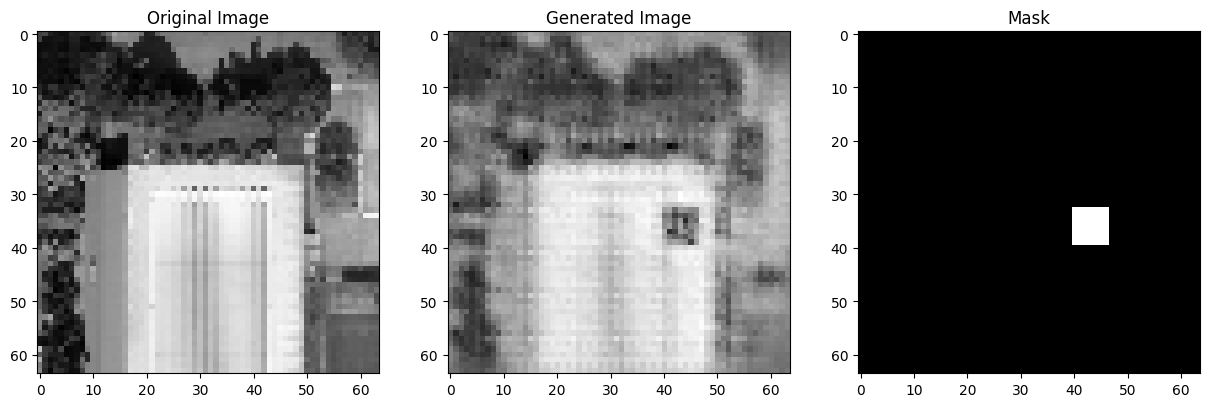

MSE Loss at Masked Area: 0.0000


In [ ]:
# prompt: load the image /content/val/img0000.png, put the black box, get the complete image using the trained model and then plot the original image, the complete image and the mse loss at the area of the black box indicated by the mask

import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/val/img0000.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Apply transformations (if any)
if transform:
    image = transform(image)

# Create masked image
processed_image, mask = create_masked_image(np.array(image))

# Convert to PyTorch tensors
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension
processed_image_tensor = transforms.ToTensor()(processed_image).unsqueeze(0).to(device)
mask_tensor = transforms.ToTensor()(mask).unsqueeze(0).to(device)

# Generate the completed image
generator.eval()
with torch.no_grad():
    generated_image_tensor = generator(processed_image_tensor)

# Calculate MSE loss at the masked area
mse_loss = nn.MSELoss()(generated_image_tensor * mask_tensor, image_tensor * mask_tensor)

# Convert tensors to NumPy arrays for plotting
original_image = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
generated_image = generated_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
mask_array = mask_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(generated_image, cmap='gray')
axes[1].set_title('Generated Image')
axes[2].imshow(mask_array, cmap='gray')
axes[2].set_title('Mask')
plt.show()

print(f"MSE Loss at Masked Area: {mse_loss.item():.4f}")


# ทดลองใช้งานกับข้อมูลชุดทดสอบ

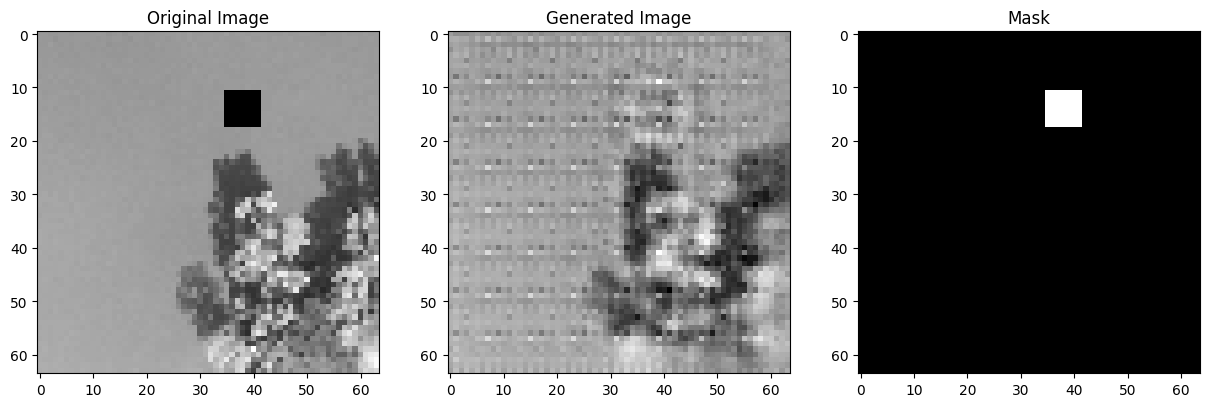

MSE Loss at Masked Area: 0.0015


In [ ]:
# prompt: load the image /content/test/img0000.png,  get the complete image using the trained model and then plot the original image, the complete image and the mse loss at the area  indicated by the mask at  /content/test_mask/img0000.png

import matplotlib.pyplot as plt
# Load the image
image_path = '/content/test/img0000.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Load the mask
mask_path = '/content/test_mask/img0000.png'
mask = Image.open(mask_path).convert('L')

# Apply transformations (if any)
# if transform:
#     image = transform(image)
#     mask = transform(mask)

# Convert to PyTorch tensors
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension
mask_tensor = transforms.ToTensor()(mask).unsqueeze(0).to(device)

# Create a masked image (black out the masked area)
processed_image_tensor = image_tensor * (1 - mask_tensor)

# Generate the completed image
generator.eval()
with torch.no_grad():
    generated_image_tensor = generator(processed_image_tensor)

# Calculate MSE loss at the masked area
mse_loss = nn.MSELoss()(generated_image_tensor * mask_tensor, image_tensor * mask_tensor)

# Convert tensors to NumPy arrays for plotting
original_image = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
generated_image = generated_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
mask_array = mask_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(generated_image, cmap='gray')
axes[1].set_title('Generated Image')
axes[2].imshow(mask_array, cmap='gray')
axes[2].set_title('Mask')
plt.show()

print(f"MSE Loss at Masked Area: {mse_loss.item():.4f}")



# ทำนายภาพใน test set และเตรียมส่งตามรูปแบบที่กำหนด

In [ ]:
# prompt: complete all image in /content/test where the mask is provided at /content/test_mask and the /content/test_bb.csv contain file name and the position of the bounding box, img_path, top,, then produce csv output having 2 columns. The first column contains file id in format {file name with out extension}_{row}_{column} e.g. img000_5_12. The second column contains intensity value in the rang [0, 255]

import pandas as pd

# Load bounding box data
bb_df = pd.read_csv('/content/test_bb.csv')

# Prepare output list
output_data = []

# Loop through test images
for index, row in bb_df.iterrows():
    img_path = row['img_path']
    top = int(row['top'])
    left = int(row['left'])  # Assuming 'left' column exists

    # Load masked image and mask
    masked_image_path = os.path.join('/content/test', img_path)
    mask_path = os.path.join('/content/test_mask', img_path)
    masked_image = Image.open(masked_image_path).convert('L')
    mask = Image.open(mask_path).convert('L')

    # Apply transformations (if any)
    if transform:
        masked_image = transform(masked_image)
        mask = transform(mask)

    # Convert to PyTorch tensors
    masked_image_tensor = transforms.ToTensor()(masked_image).unsqueeze(0).to(device)
    mask_tensor = transforms.ToTensor()(mask).unsqueeze(0).to(device)

    # Generate the completed image
    generator.eval()
    with torch.no_grad():
        generated_image_tensor = generator(masked_image_tensor)

    # Extract pixel values within the bounding box
    generated_image_np = generated_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    for i in range(top, top + 7):
        for j in range(left, left + 7):
            intensity = generated_image_np[i, j, 0] * 255  # Scale to [0, 255]
            file_id = img_path.split('.')[0] + f'_{i}_{j}'
            output_data.append([file_id, intensity])

# Create DataFrame and save to CSV
output_df = pd.DataFrame(output_data, columns=['location', 'value'])
output_df.to_csv('base_line_solution.csv', index=False)
